There is filtered version of dataset is contained in files anime_filtered.csv, animelists_filtered.csv and users_filtered.csv. It consists of users who have birth date, location and gender filled. So it contains lot less animelists data. But all important characteristics like rating mean and variation, or genres in animelists is unchanged when ommiting users with some missing data, so even with filtered data we should get same information. The filtered dataset contains:

    116 133 unique users with demographic data
    35 802 010 records in anime lists
    20 726 794 of them have ratings
    14 474 unique anime


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

In [2]:
animes = pd.read_csv('anime_filtered.csv')
users = pd.read_csv('users_filtered.csv', keep_default_na=False)
animelists = pd.read_csv('animelists_filtered.csv', keep_default_na=False)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14474 entries, 0 to 14473
Data columns (total 31 columns):
anime_id          14474 non-null int64
title             14474 non-null object
title_english     5723 non-null object
title_japanese    14440 non-null object
title_synonyms    8936 non-null object
image_url         14378 non-null object
type              14474 non-null object
source            14474 non-null object
episodes          14474 non-null int64
status            14474 non-null object
airing            14474 non-null bool
aired_string      14474 non-null object
aired             14474 non-null object
duration          14474 non-null object
rating            14474 non-null object
score             14474 non-null float64
scored_by         14474 non-null int64
rank              12901 non-null float64
popularity        14474 non-null int64
members           14474 non-null int64
favorites         14474 non-null int64
background        1057 non-null object
premiered         40

# USERS

In [4]:
users.info()
#users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116133 entries, 0 to 116132
Data columns (total 17 columns):
username                    116133 non-null object
user_id                     116133 non-null int64
user_watching               116133 non-null int64
user_completed              116133 non-null int64
user_onhold                 116133 non-null int64
user_dropped                116133 non-null int64
user_plantowatch            116133 non-null int64
user_days_spent_watching    116133 non-null float64
gender                      116133 non-null object
location                    116133 non-null object
birth_date                  116133 non-null object
access_rank                 116133 non-null object
join_date                   116133 non-null object
last_online                 116133 non-null object
stats_mean_score            116133 non-null float64
stats_rewatched             116133 non-null float64
stats_episodes              116133 non-null float64
dtypes: float64(4), int6

In [5]:
animelists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35802006 entries, 0 to 35802005
Data columns (total 11 columns):
username               object
anime_id               int64
my_watched_episodes    int64
my_start_date          object
my_finish_date         object
my_score               int64
my_status              int64
my_rewatching          object
my_rewatching_ep       int64
my_last_updated        int64
my_tags                object
dtypes: int64(6), object(5)
memory usage: 2.9+ GB


In [71]:
animelists['my_rewatching'] = animelists['my_rewatching'].replace([''],'0')

In [74]:
animelists['my_rewatching'] = animelists['my_rewatching'].astype(str).astype(float)

In [6]:
#convert to datetime
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'], unit='s')

users['birth_date'] = pd.to_datetime(users['birth_date'], errors='coerce')
users['last_online'] = pd.to_datetime(users['last_online'], errors='coerce')
users['join_date'] = pd.to_datetime(users['join_date'], errors='coerce')

In [7]:
# dropping users with invalid and obviously incorrect dates
users = users.dropna(subset=['birth_date', 'last_online', 'join_date'])

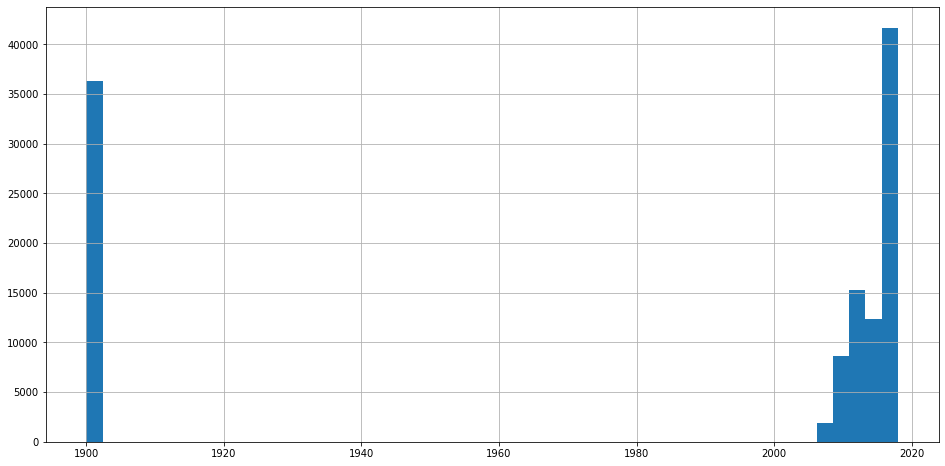

In [8]:
users['last_online'].dt.year.hist(bins=50, figsize=(16, 8))

In [9]:
usernames_arr = animelists['username'].unique()
usernames = pd.Series(data=usernames_arr, index=usernames_arr)


grouped_lists = animelists.groupby('username')
users_last_animelist_update = usernames.apply(lambda x: grouped_lists.get_group(x)['my_last_updated'].max()).to_frame(name='last_list_update')

In [10]:
users_last_animelist_update['last_list_update'] = pd.to_datetime(users_last_animelist_update['last_list_update'])
users_merged = pd.merge(users[['username', 'last_online']], users_last_animelist_update, left_on='username', right_index=True)
# users who were last online in 1900 last updated their watched anime list in 1970: 
# users.loc[users['last_online'].dt.year == 1900, 'last_online'] = users_merged[users['last_online'].dt.year == 1900]['last_list_update']

In [11]:
users_last_animelist_update['last_list_update'].dt.year.value_counts()

2018    45911
2017    14070
2016     8997
2015     7179
2014     6832
2013     6698
2010     6428
2011     5723
2012     5671
2009     5310
2008     2752
2007      491
1970       70
2006        1
Name: last_list_update, dtype: int64

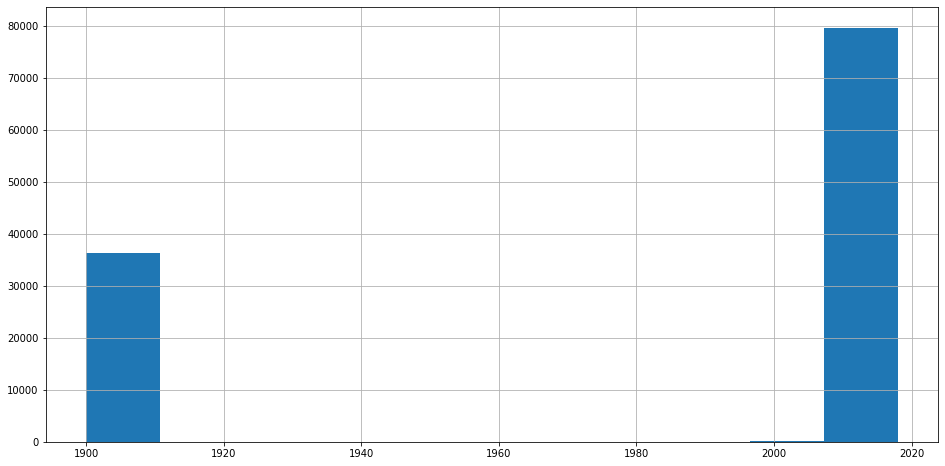

In [12]:
users['last_online'].dt.year.hist(bins=11, figsize=(16, 8))

In [13]:
# there are pple who have watched 1863 episodes of an anime!
# animelists['my_watched_episodes'].value_counts().sort_index()

In [14]:
animes['status'].unique()

array(['Finished Airing', 'Currently Airing', 'Not yet aired'],
      dtype=object)

In [15]:
merge_anime_episodes = pd.merge(animelists[['username', 'anime_id','my_watched_episodes']], animes[['anime_id','title','episodes','status']], left_on='anime_id', right_on='anime_id')
weird_animelist_data = merge_anime_episodes[(merge_anime_episodes['my_watched_episodes'] > (30*merge_anime_episodes['episodes'])) & ( ((merge_anime_episodes['status'] == 'Finished Airing') & (merge_anime_episodes['episodes'] != 0) ) |( merge_anime_episodes['status'] == 'Not yet aired'))]
weird_animelist_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2745 entries, 67611 to 35799779
Data columns (total 6 columns):
username               2745 non-null object
anime_id               2745 non-null int64
my_watched_episodes    2745 non-null int64
title                  2745 non-null object
episodes               2745 non-null int64
status                 2745 non-null object
dtypes: int64(3), object(3)
memory usage: 150.1+ KB


In [16]:
weird_animelist_data['title'].unique() # 2183 unique anime_id

array(['Chobits', 'Fruits Basket', 'Ranma ½', ...,
       'Yo! Daitouryou Trap-kun', 'Souten no Ken Re:Genesis 2nd Season',
       'Future Card Buddyfight Ace'], dtype=object)

In [17]:
weird_animelist_data[weird_animelist_data['title'] == 'Nono-chan Theater'] # episode count is incorrect-> checked myanimelist and episode count = 85!

,username,anime_id,my_watched_episodes,title,episodes,status


In [18]:
weird_animelist_data[weird_animelist_data['title'] == 'Yo! Daitouryou Trap-kun'] 

,username,anime_id,my_watched_episodes,title,episodes,status
35745310,asswithnolife,35448,65535,Yo! Daitouryou Trap-kun,2,Finished Airing


In [19]:
weird_animelist_data[weird_animelist_data['title'] == 'Future Card Buddyfight Ace']

,username,anime_id,my_watched_episodes,title,episodes,status
35799779,Helios92,37739,1,Future Card Buddyfight Ace,0,Not yet aired


In [20]:
weird_animelist_data[weird_animelist_data['title'] == 'Souten no Ken Re:Genesis 2nd Season']

,username,anime_id,my_watched_episodes,title,episodes,status
35792689,RnDNEET021,37388,1,Souten no Ken Re:Genesis 2nd Season,0,Not yet aired


In [21]:
weird_animelist_data[weird_animelist_data['title'] == 'Fruits Basket']

,username,anime_id,my_watched_episodes,title,episodes,status
100696,MurTi,120,9001,Fruits Basket,26,Finished Airing
102079,warrose,120,65535,Fruits Basket,26,Finished Airing
112338,Yashima,120,9001,Fruits Basket,26,Finished Airing
125384,thisfireburns,120,9001,Fruits Basket,26,Finished Airing


In [22]:
weird_user_count = weird_animelist_data['username'].value_counts().rename_axis('user').reset_index(name='counts')

In [23]:
weird_user_count[weird_user_count['counts'] >6]

,user,counts
0,warrose,1759
1,DeliberatorEVA,44
2,Kluxx,40
3,masato66,36
4,aKATska,34
5,Yashima,25
6,emarku,22
7,Bloodraven-,20
8,themasons,19
9,Emca_91,19


my_status in animelists tables contains integer values. This is their semantics:

    1: watching
    2: completed
    3: on hold (On-hold means that you stopped watching that anime and will resume watching it later on.)
    4: dropped
    6: plan to watch


### ban warrose:
- way too many animes with unsually high no of rewatches per episode
-

In [24]:
removed_warrose = weird_animelist_data[~(weird_animelist_data['username'] == 'warrose')]

In [25]:
removed_warrose[removed_warrose['username'] == 'DeliberatorEVA']['my_watched_episodes'].value_counts() 

9001    44
Name: my_watched_episodes, dtype: int64

### ban DeliberatorEVA:
- sizeable number of animes with a unusually high no of rewatches per episode
- not scored any of the anime
- no info in my_start_date and my_end_date columns

In [26]:
DeliberatorEVA = animelists[animelists['username'] == 'DeliberatorEVA']
# DeliberatorEVA['my_watched_episodes'].value_counts()

In [27]:
# DeliberatorEVA['my_score'].value_counts()

In [28]:
# DeliberatorEVA['my_start_date'].value_counts()

In [29]:
# DeliberatorEVA['my_finish_date'].value_counts()

###  keep Kluxx
- he still scores the animes with a large my_watched_episodes value -> he seems like a hardcore fan. looking at some of the highly watched animes, they are very very popular animes

In [30]:
Kluxx = animelists[animelists['username']=='Kluxx'] 

In [31]:
# Kluxx
# removed_warrose[removed_warrose['username'] == 'Kluxx'] 

In [32]:
# Kluxx['my_watched_episodes'].value_counts()

In [33]:
# Kluxx[Kluxx['my_watched_episodes'] == 9001 ]['my_score'].value_counts()

In [34]:
# Kluxx['my_score'].value_counts() # scores a lot of the animes he watches

In [35]:
# Kluxx['my_start_date'].value_counts() # no start date info

In [36]:
# Kluxx['my_finish_date'].value_counts() # has finish date info -> probably not reliable

 ### masato66
 - my status for all highly watched anime = completed
 - gives very high scores (9/10) to 15/36 highly watched anime
 

In [37]:
masato66 = animelists[animelists['username'] == 'masato66']

In [38]:
# masato66['my_score'].value_counts() # not very active in anime rating

In [39]:
# removed_warrose[removed_warrose['username'] == 'masato66'] 
masato66[masato66['my_watched_episodes'] == 9001]['my_rewatching_ep'].value_counts() # no data for my_rewatching/my_rewatching_ep

0    36
Name: my_rewatching_ep, dtype: int64

In [40]:
# masato66[masato66['my_watched_episodes'] == 9001]['my_score'].value_counts()
# gives very high scores to 15/36 highly watched animes 

In [41]:
# masato66['my_start_date'].value_counts()# no start_date info

In [42]:
# masato66['my_finish_date'].value_counts()# no start_date info

### aKATska

In [43]:
aKATska = animelists[animelists['username'] == 'aKATska']

In [44]:
# aKATska['my_score'].value_counts() # averages about 4/5 of the anime he watches

In [45]:
# aKATska[aKATska['my_watched_episodes'] == 0]['my_score'].value_counts() # delete rows where my_score # 0 but user has watched 0 episodes? -> only 2 suspicious rows? or the user watched the anime on another platform ?!!!
aKATska[(aKATska['my_watched_episodes'] == 0) & (aKATska['my_score'] != 0)]['my_status'].value_counts() # of the two rows, one that the user plans to watch, and one that he is watching -> delete only the row that he is planning to watch?

6    1
1    1
Name: my_status, dtype: int64

In [46]:
# aKATska[aKATska['my_watched_episodes'] == 9001]

# no data for my_rewatching/my_rewatching_ep
# ranks nearly all the highly watched anime!
# no my_start_date and my_finish_date data
# my_status = 2 = completed -> consistent

In [47]:
# aKATska['my_status'].value_counts()

### Yashima

In [48]:
yashima = animelists[animelists['username'] == 'Yashima']

In [49]:
# yashima['my_watched_episodes'].value_counts()
# he hasn't watched any episodes for 40 anime -> highest amount followed by 25 anime rewatched 9001 times! -> WEIRD data

In [50]:
# yashima[yashima['my_watched_episodes'] == 0]['my_status'].value_counts() # consistent, status is either watching/dropped/plan to watch
# yashima[(yashima['my_watched_episodes'] == 0)&(yashima['my_status'] == 6)]['my_score'].value_counts() # plan to watch yet have rated the anime! -> suspicious data!, should delete the 20 rows?

In [51]:
# yashima['my_score'].value_counts() 
# has watched 0 episodes yet scored the anime for 40 anime! -> bad data? or maybe he hasn't watched them on myanimelist website! -> not tracked!
# scores all highly watched anime, gives most of them above average/high scores 7-10.
# pretty active in rating anime! 

In [52]:
# yashima['my_rewatching'].value_counts()
# yashima[(yashima['my_watched_episodes'] == 9001) & (yashima['my_status'] == 1)] # still watching one anime?!!!

In [53]:
# animes[animes['anime_id'] == 6747] # pretty popular ranked at around 600, but still how can you have not finished a 12 episode anime that has finished airing after watching 9001 episodes?!! -> delete this data??

### emarku

In [54]:
emarku = animelists[animelists['username'] == 'emarku']

In [55]:
# emarku['my_watched_episodes'].value_counts() # 44 anime with only 1 episode watched; 23 anime with 9001 viewings!

In [56]:
# emarku['my_score'].value_counts()  # active scorer

In [57]:
# emarku[emarku['my_watched_episodes'] == 9001]['my_score'].value_counts() # rates all highly watched anime
# animes[animes['anime_id'].isin(pd.Series(emarku[emarku['my_watched_episodes'] == 9001]['anime_id'].unique()))][['anime_id','title','popularity','rank','episodes','status']]

### Bloodraven-

In [58]:
bloodraven = animelists[animelists['username'] == 'Bloodraven-']

In [59]:
# bloodraven['my_watched_episodes'].value_counts() # 20 anime with 9001 episodes watched, and 19 anime with 0 episodes watched!

In [60]:
# bloodraven[bloodraven['my_watched_episodes'] == 0]['my_status'].value_counts() # WHAT DOES my_status = 6 mean ???!!!

In [61]:
# bloodraven[bloodraven['my_watched_episodes'] == 9001]['my_score'].value_counts() # rates nearly all highly watched anime
# does not rank them that highly: 2 with a score of 5, 3 with a score of 6, 8 with a score of 7

In [62]:
# animes[animes['anime_id'].isin(pd.Series(bloodraven[bloodraven['my_watched_episodes'] == 9001]['anime_id'].unique()))][['anime_id','title','popularity','rank','episodes','status']]

### themasons

In [63]:
themasons = animelists[animelists['username'] == 'themasons']

In [64]:
# themasons['my_watched_episodes'].value_counts() # 113 unwatched anime

In [65]:
# themasons[themasons['my_watched_episodes'] == 0]['my_status'].value_counts() 

In [66]:
# a = weird_animelist_data[weird_animelist_data['username'] == 'themasons']['anime_id'].unique() #51 watches for anime with only 1 ep

In [67]:
# themasons_weird_anime = pd.Series(a)
# animes[animes['anime_id'].isin(themasons_weird_anime)][['anime_id','title','popularity','rank','episodes','status','type']]

In [68]:
# themasons_info = animelists[(animelists['anime_id'].isin(a)) &(animelists['username'] == 'themasons')]

In [69]:
# themasons_info['my_status'].value_counts() # completed all of highly watched anime
# themasons_info['my_score'].value_counts() # score of 1 yet watched them all a lot of times !!!

### Emca_91

In [70]:
Emca_91 = animelists[animelists['username'] == 'Emca_91']

In [71]:
# Emca_91['my_watched_episodes'].value_counts()

In [72]:
# Emca_91[Emca_91['my_watched_episodes'] == 9001]['my_score'].value_counts() # scored all highly watched anime
# Emca_91[Emca_91['my_watched_episodes'] == 9001]['my_status'].value_counts() # status = completed

In [73]:
e = pd.Series(Emca_91[Emca_91['my_watched_episodes'] == 9001]['anime_id'].unique())

In [74]:
Emca_91_info = animes[animes['anime_id'].isin(e)][['anime_id','title','popularity','rank','episodes','status']]

In [75]:
# Emca_91_info

In [3]:
manual_entry_anime = pd.Series(animes[(animes['status'] == 'Currently Airing') & (animes['episodes'] == 0)]['anime_id'].unique()) # episode count = unkown (converted to 0!)

In [8]:
heavily_watched_1 = pd.Series(animelists[animelists['my_watched_episodes'] == 65535]['anime_id'].unique())
heavily_watched_2 = pd.Series(animelists[animelists['my_watched_episodes'] == 9001]['anime_id'].unique())

In [15]:
manual_entry_anime[manual_entry_anime.isin(heavily_watched_1)].unique()

0        966
1         21
11      6149
48     34866
77     34566
146    13457
151    35444
156     8687
174    30151
181     1199
191    35510
200      235
224     2406
dtype: int64

In [13]:
manual_entry_anime[manual_entry_anime.isin(heavily_watched_2)].unique()

array([  21, 1199])

In [41]:
combined = pd.array([966,21,6149,34866,34566,13457,35444,8687,30151,1199,35510,235,2406],dtype=np.dtype("int64"))
animes[animes['anime_id'].isin(combined)]

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
31,966,Crayon Shin-chan,Shin Chan,クレヨンしんちゃん,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,The first English dubbed version was produced ...,Spring 1992,Fridays at 19:30 (JST),"{'Adaptation': [{'mal_id': 2435, 'type': 'mang...",TV Asahi,Funimation,Shin-Ei Animation,"Slice of Life, Comedy, Ecchi, School, Seinen","['#01: ""Doubutsuen wa Taihen da"" by Tune&#039;...","['#01: ""Uta wo Utaou"" by Daiji-Man Brothers Ba..."
34,21,One Piece,One Piece,ONE PIECE,OP,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,Several anime-original arcs have been adapted ...,Fall 1999,Sundays at 09:30 (JST),"{'Adaptation': [{'mal_id': 13, 'type': 'manga'...","Fuji TV, TAP, Shueisha","Funimation, 4Kids Entertainment",Toei Animation,"Action, Adventure, Comedy, Super Power, Drama,...","['#01: ""We Are! (ウィーアー!)"" by Hiroshi Kitadani ...","['#01: ""memories"" by Maki Otsuki (eps 1-30)', ..."
750,6149,Chibi Maruko-chan (1995),Little Miss Maruko,ちびまる子ちゃん,Maruko-chan,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,NaN,Winter 1995,Sundays at 18:00 (JST),"{'Adaptation': [{'mal_id': 15530, 'type': 'man...",Sakura Production,NaN,Nippon Animation,"Comedy, Kids, School, Slice of Life","['#01: ""Ureshii Yokan"" by Marina Watanabe (eps...","['#01: ""Hari-kiri Jiisan no Rock &#039;n&#039;..."
3441,34866,Yu☆Gi☆Oh! VRAINS,Yu-Gi-Oh! VRAINS,遊戯王VRAINS,"Yuu Gi Ou!, Yugioh",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,NaN,Spring 2017,Wednesdays at 18:25 (JST),"{'Other': [{'mal_id': 481, 'type': 'anime', 'u...","TV Tokyo, Nihon Ad Systems",NaN,Studio Gallop,"Action, Fantasy, Game, Sci-Fi, Shounen","['#1: ""With The Wind"" by Hiroaki TOMMY Tominag...","['#1: ""Believe In Magic"" by Ryoga (龍雅-Ｒｙｏｇａ-)'..."
4960,34566,Boruto: Naruto Next Generations,Boruto: Naruto Next Generations,BORUTO -NARUTO NEXT GENERATIONS-,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,The airing time was Wednesdays 17:55 between A...,Spring 2017,Thursdays at 19:25 (JST),"{'Adaptation': [{'mal_id': 87866, 'type': 'man...","TV Tokyo, Aniplex, Rakuonsha, Shueisha",Viz Media,Studio Pierrot,"Action, Adventure, Martial Arts, Shounen, Supe...","['#1: ""Baton Road (バトンロード)"" by KANA-BOON (eps ...","['#1: ""Dreamy Journey (ドリーミージャーニー)"" by The Peg..."
8737,13457,Tomodachi 8-nin,NaN,ともだち8にん,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,0,Currently Airing,...,NaN,Spring 2011,Not scheduled once per week,[],NaN,NaN,Egg,"Comedy, Kids",[],[]
9245,35444,Neko to Mata,NaN,ね子とま太,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,0,Currently Airing,...,"The series aired within #Hi_Poul, a late-night...",Spring 2017,Fridays at 01:25 (JST),[],"Fuji TV, Creek &amp; River",NaN,NaN,Supernatural,[],[]
9490,8687,Doraemon (2005),NaN,ドラえもん (2005),NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,NaN,Spring 2005,Fridays at 19:00 (JST),"{'Adaptation': [{'mal_id': 1032, 'type': 'mang...",TV Asahi,NaN,"Studio Pierrot, Shin-Ei Animation","Sci-Fi, Comedy, Kids, Shounen","['#01: ""Doraemon&#039;s Song (ドラえもんのうた)"" by 12...","['""Odore Dore Dora Doraemon Ondo 2007 (踊れ・どれ・ド..."
10957,30151,Kamiusagi Rope: Warau Asa ni wa Fukuraitaru tt...,NaN,紙兎ロペ 〜笑う朝には福来たるってマジっすか!?,Kamiusagi Rope 4,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,0,Currently Airing,...,NaN,Fall 2012,Not scheduled once per week,"{'Prequel': [{'mal_id': 13821, 'type': 'anime'...",NaN,NaN,NaN,"Slice of Life, Comedy",[],[]
11429,1199,Nintama Rantarou,NaN,忍たま乱太郎,"Ninja Boy Rantaro, Rakudaii Nintama Rantarou",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,NaN,Spring 1993,Not scheduled o

In [26]:
manual_entry_65535 = animelists[(animelists['my_watched_episodes'] == 65535) & (animelists['anime_id'].isin(combined))] # 1917 rows.

In [36]:
changed_index = animelists.set_index('my_watched_episodes')

In [38]:
changed_index.index

Int64Index([586,   0, 418,  75, 834, 808, 278, 626, 438, 460,
            ...
              0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
           dtype='int64', name='my_watched_episodes', length=35802006)

In [39]:
changed_index.index.value_counts().sort_index()

0        9616696
1        6666417
2        1309351
3         777750
4         680407
5         382411
6         574751
7         220065
8         203732
9         153289
10        442195
11        463548
12       5170319
13       2681172
14        144775
15         88230
16         54131
17         27487
18         25738
19         17727
20         72493
21         25536
22        233123
23        119270
24       1329405
25       1098290
26       1365449
27         64529
28          5464
29          8871
          ...   
3057           1
3333           1
4000           1
4012           1
4356           1
5423           1
5454           1
5690           1
6000           1
6600           1
6688           1
6724           1
6943           1
7000           1
7023           1
7337           1
7390           1
7450           1
7466           1
7500           3
7763           1
8600           1
9000          12
9001         604
9860           1
9999           5
10000          2
10015         

In [46]:
above_5000 = pd.Series(animelists[animelists['my_watched_episodes'] > 5000]['anime_id'].unique())
# animes[animes['anime_id'] == 2406] # Sazae-san is extremly long running with more 7071 episodes

In [60]:
len(above_5000)

2078

In [49]:
above_5000_info = animes[animes['anime_id'].isin(above_5000)] 

In [53]:
animelists[animelists['my_watched_episodes'] > 5000]['anime_id'].value_counts()

2406     16
21       14
20       12
1535     11
6547     10
1575     10
7054      9
4224      9
269       9
5081      7
226       7
5114      7
223       7
2001      6
121       6
431       6
235       6
1818      6
30        6
1735      6
4081      5
512       5
2034      5
356       5
33        5
232       5
430       5
2993      4
6045      4
966       4
         ..
4689      1
5539      1
2616      1
11743     1
6692      1
1358      1
2600      1
553       1
4653      1
559       1
10800     1
561       1
4761      1
565       1
2614      1
4411      1
9968      1
10812     1
6718      1
2624      1
577       1
2626      1
579       1
581       1
10822     1
5091      1
585       1
6730      1
12877     1
8192      1
Name: anime_id, Length: 2078, dtype: int64

In [52]:
# HYPOTHESIS: if you rewatch an anime series an unusually high no of times -> then you should have scored it(my_score != 0 or null!) or the popularity of the anime is high. what is the benchmark?

In [75]:
# removed_warrose['anime_id'].value_counts()

In [76]:
animes[animes['anime_id'] ==34134] # one punch man 2 is very popular... rank #92

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
9212,34134,One Punch Man 2,NaN,ワンパンマン 2,"One Punch-Man 2, One-Punch Man 2, OPM 2",https://myanimelist.cdn-dena.com/images/anime/...,TV,Web manga,0,Not yet aired,...,NaN,NaN,Unknown,"{'Adaptation': [{'mal_id': 44347, 'type': 'man...",NaN,NaN,J.C.Staff,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",[],[]


In [77]:
animes[animes['anime_id'] ==35760] # is also very popular rank #96

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
9989,35760,Shingeki no Kyojin Season 3,NaN,進撃の巨人 Season 3,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Not yet aired,...,NaN,Summer 2018,Mondays at 00:35 (JST),"{'Adaptation': [{'mal_id': 23390, 'type': 'man...",Kodansha,Funimation,Wit Studio,"Action, Military, Mystery, Super Power, Drama,...",[],[]


In [78]:
animes[animes['anime_id'] == 37675] # popularity is #280

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
12470,37675,Overlord III,NaN,オーバーロードⅢ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Light novel,0,Not yet aired,...,NaN,Summer 2018,Unknown,"{'Prequel': [{'mal_id': 35073, 'type': 'anime'...",NaN,Funimation,Madhouse,"Action, Adventure, Fantasy, Game, Magic, Super...",[],[]


In [79]:
animes[animes['anime_id'] == 1535] # popularity is #1 !

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
7913,1535,Death Note,Death Note,デスノート,DN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,37,Finished Airing,...,Death Note has been adapted into live action f...,Fall 2006,Wednesdays at 00:56 (JST),"{'Adaptation': [{'mal_id': 21, 'type': 'manga'...","VAP, Konami, Ashi Production, Nippon Televisio...",Viz Media,Madhouse,"Mystery, Police, Psychological, Supernatural, ...","['#1: ""the WORLD"" by Nightmare (eps 1-19)', '#...","['#1: ""Alumina"" by Nightmare (eps 1-19)', '#2:..."


In [80]:
animes[animes['anime_id'] == 4224] 
#anime_id = 20 : naruto has 220 episodes
#anime_id =  6547 : Angel Beats! has 13 episodes
#anime_id = 1535 : Death note has 37 episodes
#anime_id = 7054 : Kaichou wa Maid-sama! has 26 episodes
#anime_id = 4224 : Toradora! has 25 episodes

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
19,4224,Toradora!,Toradora!,とらドラ！,Tiger X Dragon,https://myanimelist.cdn-dena.com/images/anime/...,TV,Light novel,25,Finished Airing,...,Toradora! was selected as a recommended work b...,Fall 2008,Thursdays at 01:20 (JST),"{'Adaptation': [{'mal_id': 7149, 'type': 'mang...","Genco, Starchild Records, Magic Capsule, Yomiu...","NIS America, Inc.",J.C.Staff,"Slice of Life, Comedy, Romance, School","['#1: ""Pre-Parade (プレパレード)"" by Rie Kugimiya, Y...","['#1: ""Vanilla Salt (バニラソルト)"" by Yui Horie (ep..."


In [81]:
animelists[(animelists['anime_id'] == 7054) & (animelists['my_watched_episodes'] > 27)]
# MAL doesn't allow for partial rewatches, but unfortunately it seems that the only way is either by hacking or put it at a high amount before an officially episode count is released.
#  September 2014 a moderator's account got comprimised and the episode count of a lot of entries changed to 9001 episodes. If people added an entry as "completed" to their list, the episode count was automatically filled with the number of episodes (9001 in this case) 

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
803436,HaughnSolo,7054,9001,0000-00-00,0000-00-00,9,2,0.0,0,1409668322,
804337,xMelon_Chan,7054,1000,0000-00-00,0000-00-00,0,1,0.0,0,1273438187,
804499,masato66,7054,9001,0000-00-00,0000-00-00,9,2,0.0,0,1409495923,
815245,Hjortfot,7054,9001,0000-00-00,0000-00-00,10,2,0.0,0,1409602819,
829850,Kluxx,7054,9001,0000-00-00,0000-00-00,7,2,0.0,0,1409482910,
830322,Angel_D,7054,9001,0000-00-00,0000-00-00,10,2,0.0,0,1409599099,
831106,DeliberatorEVA,7054,9001,0000-00-00,0000-00-00,0,2,0.0,0,1409491295,
833640,Emca_91,7054,9001,0000-00-00,0000-00-00,7,2,0.0,0,1409684260,
834664,BravelyYou,7054,9001,2014-05-18,2014-05-22,8,2,0.0,0,1409607831,
837186,jakesta97,7054,9001,0000-00-00,0000-00-00,8,2,0.0,0,1409465555,


In [82]:
finished_airing_highly_popular = pd.array([20,1535],dtype=np.dtype("int64"))

In [83]:
high_watched_rows = animelists[animelists['my_watched_episodes'] == 65535]
# 21 = one piece a very popular anime-> so it is plausible that a user has watched the episodes 65535 times; as we do not know what action(video player streams the episode for how long?) constitutes as 'watched' -> it is possible that a user finishes an episode in many sessions! or rewatches certain parts!
# but it is difficult to rewatch a movie 65535 times!

In [84]:
anime_ids_high_watched_count = pd.Series(animelists[animelists['my_watched_episodes'] == 65535]['anime_id'].unique())
         
animes_high_watch_count_info = animes[animes['anime_id'].isin(anime_ids_high_watched_count)]

In [85]:
animes_high_watch_count_movie = animes_high_watch_count_info[animes_high_watch_count_info['type']=='Movie']

In [86]:
animes_high_watch_count_movie_ids = pd.Series(animes_high_watch_count_movie['anime_id'].unique())

In [87]:
animes_high_watch_count_movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 78 to 13807
Data columns (total 31 columns):
anime_id          333 non-null int64
title             333 non-null object
title_english     200 non-null object
title_japanese    333 non-null object
title_synonyms    241 non-null object
image_url         332 non-null object
type              333 non-null object
source            333 non-null object
episodes          333 non-null int64
status            333 non-null object
airing            333 non-null bool
aired_string      333 non-null object
aired             333 non-null object
duration          333 non-null object
rating            333 non-null object
score             333 non-null float64
scored_by         333 non-null int64
rank              330 non-null float64
popularity        333 non-null int64
members           333 non-null int64
favorites         333 non-null int64
background        37 non-null object
premiered         0 non-null object
broadcast         0 non-nul

In [88]:
high_watched_rows[high_watched_rows['anime_id'].isin(animes_high_watch_count_movie_ids)]['username'].unique() # ban these users 

array(['YoruNoMajo', 'warrose', 'dheiin_society', 'donakos'], dtype=object)

In [89]:
high_watched_rows[high_watched_rows['anime_id'].isin(animes_high_watch_count_movie_ids)]

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
1499697,YoruNoMajo,31,65535,0000-00-00,0000-00-00,1,2,0.0,0,1419479284,
1527976,YoruNoMajo,32,65535,0000-00-00,0000-00-00,0,2,0.0,0,1419479298,
1563441,warrose,43,65535,0000-00-00,0000-00-00,1,2,0.0,0,1419826464,
1583892,dheiin_society,43,65535,0000-00-00,0000-00-00,0,2,0.0,0,1252827873,
1586886,YoruNoMajo,43,65535,0000-00-00,0000-00-00,0,2,0.0,0,1419479510,
1642156,donakos,47,65535,0000-00-00,0000-00-00,1,2,0.0,0,1419482439,
2832030,warrose,393,65535,0000-00-00,0000-00-00,1,2,0.0,0,1419828122,
2922215,warrose,431,65535,0000-00-00,0000-00-00,1,2,0.0,0,1419827559,
2998943,warrose,442,65535,0000-00-00,0000-00-00,1,2,0.0,0,1419831725,
3332948,warrose,617,65535,0000-00-00,0000-00-00,1,2,0.0,0,1419828818,


In [90]:
animes['type'].unique() # air online only

array(['TV', 'Movie', 'Music', 'OVA', 'ONA', 'Special', 'Unknown'],
      dtype=object)

In [91]:
tv = pd.Series(animes_high_watch_count_info[animes_high_watch_count_info['type']=='TV']['anime_id'])
tv_high_watched = high_watched_rows[high_watched_rows['anime_id'].isin(tv)]

In [92]:
music = pd.Series(animes_high_watch_count_info[animes_high_watch_count_info['type']=='Music']['anime_id'])
music_high_watched = high_watched_rows[high_watched_rows['anime_id'].isin(music)]

In [93]:
special = pd.Series(animes_high_watch_count_info[animes_high_watch_count_info['type']=='Special']['anime_id'])
special_high_watched = high_watched_rows[high_watched_rows['anime_id'].isin(special)]

In [94]:
unknown = pd.Series(animes_high_watch_count_info[animes_high_watch_count_info['type']=='Special']['anime_id'])
special_high_watched = high_watched_rows[high_watched_rows['anime_id'].isin(special)]

In [95]:
info = animes[animes['anime_id'].isin(pd.Series(tv_high_watched['anime_id'].unique()))]
info[info['status'] == 'Not yet aired'].head()


,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
11236,35972,Fairy Tail (2018),NaN,フェアリーテイル,Fairy Tail Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Not yet aired,...,NaN,Fall 2018,Unknown,"{'Adaptation': [{'mal_id': 598, 'type': 'manga...",NaN,NaN,NaN,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",[],[]


In [96]:
not_aired_yet = pd.Series(animes[animes['status'] == 'Not yet aired']['anime_id'].unique())
animelists[(animelists['anime_id'].isin(not_aired_yet)) & (animelists['my_watched_episodes'] > 0)]['username'].unique() # delete 333 lines in animelist with anime status = 'not aired yet' but user has watched 1  or more episode!
# len(not_aired_yet)

array(['Weste', 'J151carlos', 'bigkfc2k8', 'slipkorna', 'ChronoKid',
       'DoctorSexy', 'DracoDamiani', 'SoraDeus', 'dumnorix98',
       'MuadDib42', 'lunarmonkey', 'acree', 'KatzenKeks', 'TioLaranjaDC',
       'Adramelech', 'warrose', 'Killercc', 'mangafreakZX', 'ginto',
       'Rowel_br', 'OrpheusT-elos', 'Agumon', 'SoubiOBAKE', 'Uzumakis',
       'elitemaster07', 'Weiss_', 'essawariacik', 'Kartunga', 'Biga',
       'AzenaKira', 'VASVISM', 'demonspire', 'tessellated', 'Meera_Stm',
       'Natsuki12', 'whostae', 'sinnige69', 'Mante', 'Thiago_maciel',
       'matiasotaku', 'Holly_Holley', 'C_Mpot', 'Eagle360',
       'MechaFan-RX-78-2', 'elenaaroxanaa', 'saneok', 'Namiangaki_PL',
       'Fishcaek-Chan', 'Lelouch1299', 'Jeffersonshi', 'LadyBird',
       'Neko_in_LCL', 'Krombopulos', 'Fullbuster1597', 'st3v3n',
       'hasaczu93', 'MAADCity1', 'dr_feels1', 'iddqd__', 'black_04035',
       'Gnomerman', 'ribika01', 'N_44_66', 'Hasegava_Taizo', 'jugann',
       'kokono', 'Lin_Tamakie', 'K

In [97]:
users_questionable = pd.Series(animelists[(animelists['anime_id'].isin(not_aired_yet)) & (animelists['my_watched_episodes'] > 0)]['username'].unique())                                                            

In [98]:
users_questionable

0              Weste
1         J151carlos
2          bigkfc2k8
3          slipkorna
4          ChronoKid
5         DoctorSexy
6       DracoDamiani
7           SoraDeus
8         dumnorix98
9          MuadDib42
10       lunarmonkey
11             acree
12        KatzenKeks
13      TioLaranjaDC
14        Adramelech
15           warrose
16          Killercc
17      mangafreakZX
18             ginto
19          Rowel_br
20     OrpheusT-elos
21            Agumon
22        SoubiOBAKE
23          Uzumakis
24     elitemaster07
25            Weiss_
26      essawariacik
27          Kartunga
28              Biga
29         AzenaKira
           ...      
920       tsKChimera
921    DemonationDog
922        Kamek1999
923             a666
924      CursedVenom
925        luislifer
926        mattprinc
927          joker92
928            Gesus
929          OWARYUU
930         Ladrason
931      Michiandreb
932     redxkiller45
933          Atomind
934     Nagareboshi_
935          Animeoh
936       Dra

In [99]:
data = animelists[animelists['username'].isin(users_questionable)]